In [1]:
from matplotlib import pyplot as plt
import polars as pl
import polars_h3 as plh3

from diskcache import FanoutCache
import h3
import pydeck as pdk
import pandas as pd
from typing import Optional
import matplotlib.pyplot as plt
from datetime import date
import numpy as np
import osmnx as ox
import networkx as nx
from tqdm import tqdm

In [2]:
# def download_city_network(city_name, network_type='walk'):
#     """Download an entire city network once"""
#     print(f"Downloading {network_type} network for {city_name}...")
#     G = ox.graph_from_place(city_name, network_type=network_type)
#     return G

# G = download_city_network('Warsaw, Poland')

In [3]:
# def calculate_walking_distance(h1, h2):  
#     lat1, lon1 = h3.cell_to_latlng(h1)
#     lat2, lon2 = h3.cell_to_latlng(h2)
    
#     origin_node = ox.distance.nearest_nodes(G, lon1, lat1)
#     destination_node = ox.distance.nearest_nodes(G, lon2, lat2)
    
#     # Calculate the shortest path
#     try:
#         route = nx.shortest_path(G, origin_node, destination_node, weight='length')
#         # Calculate the total distance of the route in meters
#         distance = 0
#         for u, v in zip(route[:-1], route[1:]):
#             # Get the length of this edge
#             data = G.get_edge_data(u, v, 0)  # 0 is the default key for MultiDiGraphs
#             distance += data.get('length', 0)
#         return distance / 1000
#     except nx.NetworkXNoPath:
#         return "No path found between these points."

import requests
import json
import h3

session = requests.Session()

def valhalla_distance(h1, h2, costing='pedestrian'):
    """Calculate walking distance between two H3 cells using Valhalla"""
    # Convert H3 cells to lat/lon
    lat1, lon1 = h3.cell_to_latlng(h1)
    lat2, lon2 = h3.cell_to_latlng(h2)
    
    # Create Valhalla routing request
    request = {
        "locations": [
            {"lat": lat1, "lon": lon1},
            {"lat": lat2, "lon": lon2}
        ],
        "costing": costing,  # pedestrian, bicycle, auto, etc.
        "directions_options": {"units": "kilometers"}
    }
    
    # Send request to Valhalla service
    response = session.post(
        'http://localhost:8002/route',
        json=request
    )
    
    # Parse response
    if response.status_code == 200:
        result = response.json()
        # Extract the distance in kilometers
        if 'trip' in result and 'legs' in result['trip'] and len(result['trip']['legs']) > 0:
            return result['trip']['legs'][0]['summary']['length']  # in kilometers
    
    return None

import polars as pl
from concurrent.futures import ThreadPoolExecutor
from functools import partial

def compute_distances_parallel(df, main_h3id, workers=15):
    def wrapper(row, main_h3id):
        return valhalla_distance(row, main_h3id)

    with ThreadPoolExecutor(max_workers=workers) as executor:
        distances = list(executor.map(partial(wrapper, main_h3id=main_h3id), df['h3res13'].to_list()))

    df = df.with_columns(pl.Series(name="distance_km", values=distances).alias('walking_distance_from_station_km'))
    return df

In [4]:
traffic = pl.read_parquet('../for_participants/data_parquet/traffic_train.parquet')

signals = pl.read_parquet('../for_participants/data_parquet/signals.parquet')
roads = pl.read_parquet('../for_participants/data_parquet/roads.parquet')
pois = pl.read_parquet('../for_participants/data_parquet/pois.parquet')

signals = signals.with_columns([
    plh3.cell_to_latlng("h3res13").list.to_struct(fields=["lat", "lon"]).alias("latlng")
]).unnest("latlng")

pois = pois.with_columns([
    plh3.cell_to_latlng("h3res13").list.to_struct(fields=["lat", "lon"]).alias("latlng")
]).unnest("latlng")

In [5]:
pois

h3res13,accommodation,active_life,arts_and_entertainment,attractions_and_activities,automotive,beauty_and_spa,business_to_business,eat_and_drink,education,financial_service,health_and_medical,home_service,mass_media,pets,private_establishments_and_corporates,professional_services,public_service_and_government,real_estate,religious_organization,retail,structure_and_geography,travel,lat,lon
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64
"""8d1f52240b2923f""",1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,52.161318,20.935229
"""8d1f52240b2ddbf""",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,52.161778,20.934252
"""8d1f52240b404ff""",0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,52.160497,20.937711
"""8d1f52240b434bf""",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,52.16014,20.937959
"""8d1f52240b636bf""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,52.161157,20.937891
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""8d1f53d9e329bbf""",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,52.345513,20.926222
"""8d1f53d9e354d3f""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,52.344447,20.926866
"""8d1f53d9e3746ff""",0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,52.345206,20.926946


In [6]:
output = []

window_size = 0.02

for (station_id, station_h3, lat, lon), traffic_for_station_and_day in tqdm(
    traffic.group_by(['station_id', 'h3res13', 'lat', 'lon']),
    total=len(list(traffic.group_by(['station_id'])))
):
    filtered_pois = pois.filter(
        (pl.col("lat") >= lat-window_size) & (pl.col("lat") <= lat+window_size) &
        (pl.col("lon") >= lon-window_size) & (pl.col("lon") <= lon+window_size)
    ).with_columns(
        [
            pl.lit(station_id).alias("station_id"),
            pl.lit(station_h3).alias("station_h3"),
            pl.lit(lat).alias("station_lat"),
            pl.lit(lon).alias("station_lon")
        ]
    ).with_columns(
        [
            plh3.great_circle_distance(
                "lat", "lon", "station_lat", "station_lon", unit="km"
            ).alias('distance_from_station_km')
        ]
    ).filter(
        pl.col('distance_from_station_km') <= 1
    )

    filtered_pois_with_distance = compute_distances_parallel(filtered_pois, station_h3)

    output.append(filtered_pois_with_distance)

100%|██████████████████████████████████████████████████████████████████████████████████| 70/70 [03:58<00:00,  3.41s/it]


In [11]:
pl.concat(output, how="vertical").write_parquet('pois_walking_distance.parquet')

In [16]:
final_df = pl.concat(output, how="vertical")

In [17]:
final_df

h3res13,accommodation,active_life,arts_and_entertainment,attractions_and_activities,automotive,beauty_and_spa,business_to_business,eat_and_drink,education,financial_service,health_and_medical,home_service,mass_media,pets,private_establishments_and_corporates,professional_services,public_service_and_government,real_estate,religious_organization,retail,structure_and_geography,travel,lat,lon,station_id,station_h3,station_lat,station_lon,distance_from_station_km,walking_distance_from_station_km
str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,str,str,f64,f64,f64,f64
"""8d1f53cb0043b3f""",0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,52.292188,20.971335,"""3378""","""8d1f53cb02e58ff""",52.2889,20.981,0.752389,0.829
"""8d1f53cb028103f""",0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,52.287403,20.976508,"""3378""","""8d1f53cb02e58ff""",52.2889,20.981,0.34809,0.915
"""8d1f53cb028107f""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,52.287402,20.976612,"""3378""","""8d1f53cb02e58ff""",52.2889,20.981,0.341866,0.907
"""8d1f53cb028137f""",0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,52.287402,20.976822,"""3378""","""8d1f53cb02e58ff""",52.2889,20.981,0.329527,0.901
"""8d1f53cb02819bf""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,52.287555,20.976356,"""3378""","""8d1f53cb02e58ff""",52.2889,20.981,0.34959,0.891
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""8d1f53536dac47f""",0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,2,0,0,0,2,0,0,52.173722,21.034183,"""5393""","""8d1f53536cdb97f""",52.169,21.0414,0.719911,0.818
"""8d1f53536dae9bf""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,52.173622,21.033761,"""5393""","""8d1f53536cdb97f""",52.169,21.0414,0.732058,0.847
"""8d1f53536db11bf""",0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,52.173121,21.031963,"""5393""","""8d1f53536cdb97f""",52.169,21.0414,0.790281,1.015


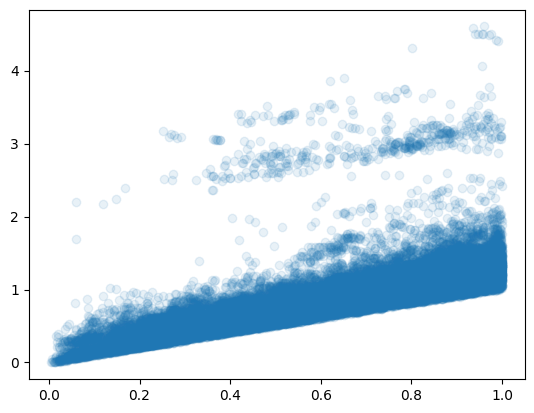

In [20]:
plt.scatter(final_df['distance_from_station_km'], final_df['walking_distance_from_station_km'], alpha=0.1)